In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import f1_score
np.random.seed(1)

## 1. Prepare Data

#### 1.1. Load data. The data should contain 303 rows, and 11 columns.

In [2]:
heart = pd.read_csv("heart.csv.bz2", sep=",")
heart = heart.drop(columns=["slp", "oldpeak", "thall"])
print(f"Rows, Columns: {heart.shape}\n")

Rows, Columns: (303, 11)



#### 1.2. Do some basic checks. Do we have any missing values? What are the data types? What are ranges of numeric variables, and possible values of categorical variables? What is the percentage of heart attack among these patients? Compare the values with the documentation and comment what do you see.

In [3]:
print("Number of NaN values in each column:")
print(heart.isna().sum())
print("\nData Type:")
print(heart.dtypes)
n_var = ["age", "trtbps", "chol", "thalachh"]
c_var = ["sex", "cp", "fbs", "restecg", "exng", "caa", "output"]
print("\nNumerical Variables (range):")
for i in n_var:
    print(f"{i}: {np.min(heart[i])} - {np.max(heart[i])}")
print("\nCategorical Variables (values):")
for i in c_var:
    print(f"{i}: {np.arange(np.min(heart[i]), np.max(heart[i])+1)}")
per_ha = heart[heart.output == 1].shape[0]
print(f"Percent Heart Attack: {per_ha/303 * 100}%")

Number of NaN values in each column:
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
caa         0
output      0
dtype: int64

Data Type:
age         int64
sex         int64
cp          int64
trtbps      int64
chol        int64
fbs         int64
restecg     int64
thalachh    int64
exng        int64
caa         int64
output      int64
dtype: object

Numerical Variables (range):
age: 29 - 77
trtbps: 94 - 200
chol: 126 - 564
thalachh: 71 - 202

Categorical Variables (values):
sex: [0 1]
cp: [0 1 2 3]
fbs: [0 1]
restecg: [0 1 2]
exng: [0 1]
caa: [0 1 2 3 4]
output: [0 1]
Percent Heart Attack: 54.45544554455446%


For a few of the categorical values, there was actually more values in the data for the category than stated in the documentation. For example caa was supposed to have 0-3, but the data turned out to be 0-4. The same happens for cp.

#### 1.3. You probably noticed that all the above variables are coded as numbers. However, not all of these are in fact of numeric (interval, ratio) measure type. Which variables above are inherently non numeric (nominal or ordinal)?

The categorical values are non numeric, with sex, fbs, and exng being nominal, and cp, restecg, and caa being ordinal.

#### We are going to use sklearn library. Construct the outcome vector y and the design matrix X. It should include all explanatory variable (but not output!). The variables that are inherently categorical should be converted to categorical. How many columns do you get?

In [4]:
y = heart["output"]
X = heart.drop(columns=["output"])
X = pd.get_dummies(X, columns=["cp", "restecg", "caa"], drop_first = True)
print(X)

     age  sex  trtbps  chol  fbs  thalachh  exng  cp_1  cp_2  cp_3  restecg_1  \
0     63    1     145   233    1       150     0     0     0     1          0   
1     37    1     130   250    0       187     0     0     1     0          1   
2     41    0     130   204    0       172     0     1     0     0          0   
3     56    1     120   236    0       178     0     1     0     0          1   
4     57    0     120   354    0       163     1     0     0     0          1   
..   ...  ...     ...   ...  ...       ...   ...   ...   ...   ...        ...   
298   57    0     140   241    0       123     1     0     0     0          1   
299   45    1     110   264    0       132     0     0     0     1          1   
300   68    1     144   193    1       141     0     0     0     0          1   
301   57    1     130   131    0       115     1     0     0     0          1   
302   57    0     130   236    0       174     0     1     0     0          0   

     restecg_2  caa_1  caa_

I have 16 columns

#### 1.5. Split data (both y and X) into work and testing chunks (80/20). Do not look at the testing chunk. Your work data should be 242 and test data 61 rows or so.

In [5]:
Xwk, Xtst, ywk, ytst = train_test_split(X, y, test_size=0.2)
print(Xwk.shape)
print(Xtst.shape)

(242, 16)
(61, 16)


#### 1.6. Save your test data (both y and X to a file to be used later. Delete all datasets that contain the testing data from memory. This includes the original data frame, X, and y, and the test data itself.

In [6]:
Xtst.to_csv("xtest.csv")
ytst.to_csv("ytest.csv")
del heart, X, y, Xtst, ytst

#### 1.7. Split your work data into training and validation chunks (80/20). Below, you will only need thesetwo chunks, until the very last question.

In [7]:
Xtr, Xval, ytr, yval = train_test_split(Xwk, ywk, test_size=0.2)
print(Xtr.shape)
print(Xval.shape)

(193, 16)
(49, 16)


## 2. Logistic Regression

#### 2.1. What do you think, which measure–precision, recall, or F-score–will be most relevant in order to make this model more applicable in medicine? Explain!

In the field of medicine I think that it is better to be safe than sorry, which means assuming that having a heart attack is the positive that I believe that minimizing false negatives is more important than false positives. Therefor I think that recall would be better than precision. However, I also believe in not wasting medical resources, therefore choosing the F-score as my measure of precision would be most relevant in making this model more applicable since the F-Score attempt to find the balance between precision and recall.

#### 2.2. First, imagine we create a very simple model (“naive model”) that predicts everyone the same result (attack or no attack), whichever category is more common in data (the majority category). How would the confusion matrix of this model look like? What are the corresponding accuracy, precision and recall? Show this confusion matrix and explain!

In [8]:
print(f"Cases with No HA: {len(ywk[ywk == 0])}")
print(f"Cases with HA: {len(ywk[ywk == 1])}")

Cases with No HA: 108
Cases with HA: 134


| | | | |
| -------- | ------------: | ------:| -----:|
|**Actual/Predicted** | No HA | HA | Total |
| No HA | 0 | 118 | 118 |
| HA | 0 | 124 | 124 | 
| | 0 | 242 | 242 |

In [9]:
TN = 0
FP = 118
FN = 0
TP = 124
T = 242

In [10]:
def metrics_summary(TN, FP, FN, TP, T):
    A = (TN+TP)/T
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    F = 2/(1/P + 1/R)
    return (A, P, R, F)

In [11]:
summary = metrics_summary(TN, FP, FN, TP, T)
print(f"Accuracy: {summary[0]}")
print(f"Precision: {summary[1]}")
print(f"Recall: {summary[2]}")
print(f"F-Score: {summary[3]}")

Accuracy: 0.512396694214876
Precision: 0.512396694214876
Recall: 1.0
F-Score: 0.6775956284153004


The accuracy is the percentage of correctly predicted values, because having a heart attack is the majority category, therefore we predict all to be heart attack. This means that the cases without heart attack are predicted wrong, hence only 51.239% of the cases are predicted correctly. Precision will be the same value because precision is the percentages of predicted positives that turn out to be correct, since we predicted all to be positive, the recall would be 51.239% as well. The recall is 1 because we predicted all cases to be positive, therefore all actual positive cases are correctly identified.

#### 2.3. Construct a logistic regression model in sklearn and fit it with your training data

In [12]:
mlogi = LogisticRegression(max_iter = 1000)
_ = mlogi.fit(Xtr, ytr)

#### 2.4. Use your validation data to predict the outcome—that is, whether someone has heart attack or not. Print out the first 10 labels. Which values denote attack, which ones non-attack?

In [13]:
predictions = mlogi.predict(Xval)
first10 = predictions[:10]
j = 1
for i in first10:
    if i == 1:
        print(f"Value {j}: Attack")
    else:
        print(f"Value {j}: Non-Attack")
    j+=1

Value 1: Attack
Value 2: Non-Attack
Value 3: Attack
Value 4: Attack
Value 5: Non-Attack
Value 6: Attack
Value 7: Attack
Value 8: Attack
Value 9: Attack
Value 10: Non-Attack


#### 2.5. Display the confusion matrix.

In [14]:
from sklearn.metrics import confusion_matrix
def convert(pre):
    y_predict = []
    for i in pre:
        if i > 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    return y_predict
print(confusion_matrix(yval, predictions))
TP = 26
FN = 2
FP = 8
TN = 13
T = 49

[[13  8]
 [ 2 26]]


| | | | |
| -------- | ------------: | ------:| -----:|
|**Actual/Predicted** | No HA | HA | Total |
| No HA | 13 | 8 | 21|
| HA | 2 | 26 | 28 | 
| | 15 | 34 | 49 |

#### 2.6. Compute and display accuracy and the measure you suggested in 1. How do these results compare to the naive model?

In [31]:
summary = metrics_summary(TN, FP, FN, TP, T)
print(f"Accuracy: {summary[0]}")
print(f"F-Score: {summary[3]}")

Accuracy: 0.7959183673469388
F-Score: 0.8387096774193549


The accuracy and F-Score is both higher in the logistic regression model than in the naive model. The naive model has an accuracy of of 0.51239 which means it only got 51.239% of the cases correct, however in the logistic regression model the accuracy is 0.79591 which means the model got 79.591% of the cases correct. The F-score takes the harmonic mean of both the precision and recall, and a higher F-Score means that the model performs well in both precision and recall, the F-Score of the naive model is 0.67759 while the F-Score of the logistic model is 0.83871 which means the logistic model performs better in both precision and recall.

## 3. Other ML methods

### 3.1. Nearest Neighbors

#### 3.1.1. Loop over different number of neighbors k (from a single neighbor to all data points). For each k value: 
#### • train the model on training data and
#### • compute the performance (accuracy and your suggested measure) on training data
#### • compute the performance (accuracy and your suggested measure) on validation data 
#### • store the performance value(s)

In [16]:
kval = range(1, len(Xtr))
acc_tr = []
acc_val = []
fscore_tr = []
fscore_val = []
for k in kval:
    mNeigh = KNeighborsRegressor(k)
    _ = mNeigh.fit(Xtr, ytr)
    predictions_tr = mNeigh.predict(Xtr)
    predictions_val = mNeigh.predict(Xval)
    acc_tr.append(mNeigh.score(Xtr, ytr))
    fscore_tr.append(f1_score(ytr, convert(predictions_tr)))
    acc_val.append(mNeigh.score(Xval, yval))
    fscore_val.append(f1_score(yval, convert(predictions_val)))

#### 3.1.2. Make a plot where you show both the training and validation performance as a function of k

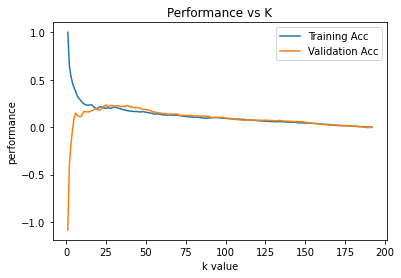

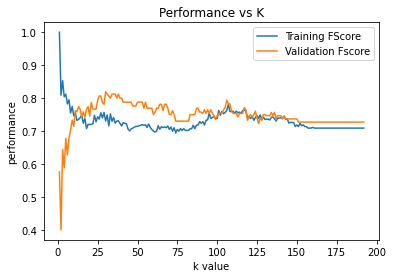

In [17]:
_ = plt.plot(kval, acc_tr)
_ = plt.plot(kval, acc_val)
plt.xlabel("k value")
plt.ylabel("performance")
plt.title(label = "Performance vs K")
plt.legend(["Training Acc", "Validation Acc"])
plt.show()
_2 = plt.plot(kval, fscore_tr)
_2 = plt.plot(kval, fscore_val)
plt.xlabel("k value")
plt.ylabel("performance")
plt.title(label = "Performance vs K")
plt.legend(["Training FScore", "Validation Fscore"])
plt.show()

#### 3.1.3. Find the k value that gives you the best performance (both accuracy and your suggested measure). How good measures do you get? How do they compare with the naive model? How do they compare with logistic regression?

In [18]:
index_acc = np.argmax(acc_val)
index_fscore = np.argmax(fscore_val)
print(f"The K value with the best accuracy is {index_acc + 1} with {acc_val[index_acc]}")
print(f"The K value with the best Fscore is {index_fscore + 1} with {fscore_val[index_fscore]}")


The K value with the best accuracy is 25 with 0.2334666666666666
The K value with the best Fscore is 30 with 0.819672131147541


The accuracy is lower than both the naive model and the logistic model with 0.23346 at k value = 25 which is a really low accuracy. While the F-Score is better than the naive model but worse than the logistic model with 0.81967 at k value = 30, which is not a bad value for F-Score.

#### 3.1.4. Which k values (if any) are overfitting, which ones underfitting? Why do the model performance measure flatten out when k is very large?

For the accuracy, the k values at the beginning around 1 to 15 are over fitting meaning large training acc but low validation acc. After the two accuracy coverges, the k values of the model is underfitting, having both low training acc and low validation acc. Performance flattens out when k is large because the model becomes more stable due to having a larger portion of the dataset.

### 3.2. Decision trees

#### 3.2.1. Loop over different values of max depth, from 1 to 10. For each max depth value:
#### • train the model on training data and . . .
#### • . . . compute the performance (accuracy and your suggested measure) on training data
#### • compute the performance (accuracy and your suggested measure) on validation data 
#### • store the performance value(s) in a list or array

In [19]:
from sklearn.tree import DecisionTreeClassifier
acc_tr = []
acc_val = []
fscore_tr = []
fscore_val = []
for d in range(1,10):
    mTree = DecisionTreeClassifier(max_depth = d).fit(Xtr, ytr)
    predictions_tr = mTree.predict(Xtr)
    predictions_val = mTree.predict(Xval)
    acc_tr.append(mTree.score(Xtr, ytr))
    fscore_tr.append(f1_score(ytr, convert(predictions_tr)))
    acc_val.append(mTree.score(Xval, yval))
    fscore_val.append(f1_score(yval, convert(predictions_val)))

#### 3.2.2. Make a plot where you show both the training and validation performance as a function of k.

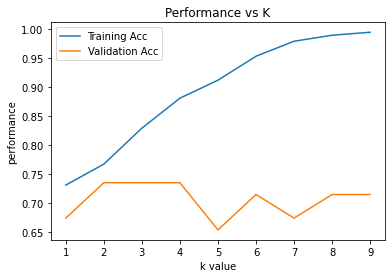

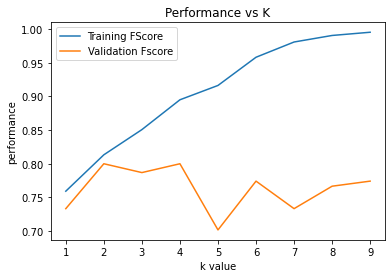

In [20]:
kval = kval = range(1, 10)
_ = plt.plot(kval, acc_tr)
_ = plt.plot(kval, acc_val)
plt.xlabel("k value")
plt.ylabel("performance")
plt.title(label = "Performance vs K")
plt.legend(["Training Acc", "Validation Acc"])
plt.show()
_2 = plt.plot(kval, fscore_tr)
_2 = plt.plot(kval, fscore_val)
plt.xlabel("k value")
plt.ylabel("performance")
plt.title(label = "Performance vs K")
plt.legend(["Training FScore", "Validation Fscore"])
plt.show()

#### 3.2.3. Find the k value that gives you the best performance (both accuracy and your suggested measure). How good measures do you get? How do they compare with the naive model? How do they compare with logistic regression?

In [21]:
index_acc = np.argmax(acc_val)
index_fscore = np.argmax(fscore_val)
print(f"The K value with the best accuracy is {index_acc + 1} with {acc_val[index_acc]}")
print(f"The K value with the best Fscore is {index_fscore + 1} with {fscore_val[index_fscore]}")

The K value with the best accuracy is 2 with 0.7346938775510204
The K value with the best Fscore is 2 with 0.7999999999999999


The accuracy is lower than the logistic model but better than the naive model with 0.73469 at depth 2. The Fscore is lower than the logistic model and the naive model with 0.79999 at depth 2 as well.

#### 3.2.4. Which k values (if any) are overfitting, which ones underfitting?

The larger k values after depth 2 start to become over fitting, there wasn't any k values that seemed underfitting.

#### 3.2.5. Out of the models you tried–logistic, k-NN, and trees–which is the best model in terms of validation accuracy? How much was the accuracy over what the naive model gave you? In the next two questions you are using just that model.

The logistic method gave me the best validation accuracy of 0.79591 which is 0.28352 greater than 0.51239 of the naive model accuracy, the most out of the three models

## 4. How confident are we in the results?

#### 4.1. Predict the probability of having a heart attack Pr(output = 1|x) for everyone in data. Print out the first 10 probabilities.

In [26]:
predictions = mlogi.predict_proba(Xval)
pre = mlogi.predict(Xval)
print([i[1] for i in predictions[:10]])

[0.12246894472578673, 0.8264417178857605, 0.34115978102859823, 0.2892198608751202, 0.7049578810003357, 0.2845246783221389, 0.07097046066697099, 0.3288103829925796, 0.3843599641228227, 0.9707239825793716]


#### 4.2. Make a histogram of your predictions. What do you see–are the predicted probabilities more extreme (either 0 or 1) or in the middle (around 0.5)?

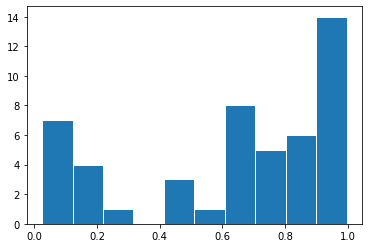

In [27]:
_ = plt.hist([i[1] for i in predictions], edgecolor = "w")

The predicted values are more extreme towards 1

#### 4.3. Why does predicted probability around 0.5 indicate that the results are uncertain?

Because that means that both cases are plausible and equally likely to happen, which then the would make the model uncertain about which case it belongs to.

## 5. Final model goodness

#### 5.1. Take your best model, the one you used in Question 4. But now fit it with complete work data, notjust with your training data.

In [29]:
mlogi = LogisticRegression(max_iter = 1000)
_ = mlogi.fit(Xwk, ywk)

#### 5.2. Load your test data, the one you saved earlier. Use the test data to compute test accuracy. This is your final model performance measure. Show it!

In [34]:
xtest = pd.read_csv("xtest.csv")
ytest = pd.read_csv("ytest.csv")
xtest
mlogi.predict(xtest)
mlogi.score(xtest, ytest)

    Unnamed: 0  output
0          204       0
1          159       1
2          219       0
3          174       0
4          184       0
..         ...     ...
56           0       1
57         288       0
58         259       0
59         179       0
60         110       1

[61 rows x 2 columns]


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Unnamed: 0
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 17 features, but LogisticRegression is expecting 16 features as input.